<a href="https://colab.research.google.com/github/Elberdan/Behaviour-Score/blob/main/BEHAVIOUR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 00. CONEXÃO AO DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 01. BIBLIOTECAS

In [ ]:
# Instalacões necessárias
! pip install optbinning
! pip install dython


In [ ]:
# Ativando as bibliotecas
import pandas as pd # Análises Estatística
import datetime # Manipulação de datas
import numpy as np # manipulação de dados
import pickle # Salvar objetos
import scipy.stats as ss #matriz crammer
import statsmodels.api as sm



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from scipy import stats
from sklearn.model_selection import train_test_split 
from dython.nominal import associations
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
from optbinning import OptimalBinning
from optbinning import BinningProcess

# 02. INFORMAÇÕES GERAIS


### 02.1. Chamando a base já carregada nesse notebook

In [ ]:
# Importando a base que será chamda de Neon
neon = pd.read_csv('UCI_Credit_Card.csv')

### 02.2. Verificar informações iniciais sobre a base de dados.

In [ ]:
# Dimensão
neon.shape

In [ ]:
# Nome das colunas
neon.columns

In [ ]:
#Primeiro muda a configuração de exibição, caso contrário não aparecerá a opção de ver todas colunas.
pd.options.display.max_columns = None

# Visualizar até 5 linhas
neon.head(5)

In [ ]:
# Verificando a taxa inad.
neon['default.payment.next.month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default.payment.next.month, dtype: float64

# 03. CRIANDO SAFRA

03.1 Contexto

As variáveis "PAY" e "BILL_AM" são referentes a captações mensais, ou seja, temos 6 meses de informações transacionais dos clientes. Como não há datas do dia que foi observado essas informações, vamos simular algumas safras como data de referência. 

In [ ]:
# Dividindo cada safra em 10% da base
test = pd.DataFrame({
    'datas' : ['200501', 
               '200502',
               '200503', 
               '200504', 
               '200505',
               '200506', 
               '200507', 
               '200508', 
               '200509',
               '200510'],
    'rep' : [3000,3000,3000,3000,3000,3000,3000,3000,3000,3000]
})

# Repetindo as safras
SAFRA=test.loc[test.index.repeat(test.rep)].reset_index(drop=True)



In [ ]:
# inserindo na base a nova variável criada de safra, formantando para número inteiro
neon['Safra']=SAFRA['datas'].astype(int)

# Visualizando
neon.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,Safra
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,200501
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,200501
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,200501
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,200501
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,200501


In [ ]:
# Confirmando a volumetria da safra, que determinamos em 10% cada.
neon['Safra'].value_counts(normalize=True)

200501    0.1
200502    0.1
200503    0.1
200504    0.1
200505    0.1
200506    0.1
200507    0.1
200508    0.1
200509    0.1
200510    0.1
Name: Safra, dtype: float64

# 04. VARIÁVEIS HISTÓRICAS

In [ ]:
#Criando uma lista com as variáveis com valores por safra

#CONTAS
neonlist=['BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

#PAGAMENTOS
neonlist2=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']


In [ ]:
# Será considerada medidas na janela de 6 meses

# Variáveis de SOMA
neon['SOMA_BILL_6'] = neon[neonlist].sum(axis=1) # Vamos somar as colunas BILL_AMT(i), com i=1,...,6 
neon['SOMA_PAY_6'] = neon[neonlist2].sum(axis=1) # Vamos somar as colunas PAY_AMT(i), com i=1,...,6 

# Variáveis de MÉDIA
neon['MEDIA_BILL_6'] = neon[neonlist].mean(axis = 1)
neon['MEDIA_PAY_6'] = neon[neonlist2].mean(axis = 1)

# Variáveis de MAXIMO
neon['MAX_BILL_6'] = neon[neonlist].max(axis = 1)
neon['MAX_PAY_6'] = neon[neonlist2].max(axis = 1)

# Variáveis de MINIMO
neon['MIN_BILL_6'] = neon[neonlist].min(axis = 1)
neon['MIN_PAY_6'] = neon[neonlist2].min(axis = 1)


In [ ]:
# Visualizando as variáveis criadas
neon[['SOMA_BILL_6','SOMA_PAY_6','MEDIA_BILL_6','MEDIA_PAY_6','MAX_BILL_6','MAX_PAY_6','MIN_BILL_6','MIN_PAY_6']].head()

,SOMA_BILL_6,SOMA_PAY_6,MEDIA_BILL_6,MEDIA_PAY_6,MAX_BILL_6,MAX_PAY_6,MIN_BILL_6,MIN_PAY_6
0,7704.0,689.0,1284.000000,114.833333,3913.0,689.0,0.0,0.0
1,17077.0,5000.0,2846.166667,833.333333,3455.0,2000.0,1725.0,0.0
2,101653.0,11018.0,16942.166667,1836.333333,29239.0,5000.0,13559.0,1000.0
3,231334.0,8388.0,38555.666667,1398.000000,49291.0,2019.0,28314.0,1000.0
4,109339.0,59049.0,18223.166667,9841.500000,35835.0,36681.0,5670.0,679.0


# 05. DESENVOLVIMENTO, VALIDAÇÃO E OUT OFF TIME

### 05.1. Desenvolvimento e OOT

In [ ]:
# Separando base em desenvolvimento
DEV = neon.loc[neon['Safra'] < 200508]

In [ ]:
# Separando base em OOT
OOT = neon.loc[neon['Safra'] >= 200508]

In [ ]:
# Vizualiando as safras contidas em cada amostra
DEV['Safra'].value_counts(normalize=True)


200501    0.142857
200502    0.142857
200503    0.142857
200504    0.142857
200505    0.142857
200506    0.142857
200507    0.142857
Name: Safra, dtype: float64

In [ ]:
OOT['Safra'].value_counts(normalize=True)

200508    0.333333
200509    0.333333
200510    0.333333
Name: Safra, dtype: float64

### 05.2. Desenvolvimento[ Treino e Teste]

In [ ]:
# Vamo criar algumas divisoes, onde:
# X_train terão as covariáveis e Y_train a var. resposta (70% da base DEV)
# X_test e Y_train as mesmas configuracões anteriores (30% da base)
# Manter as partições sempre iguais com a semente 2005

X_train, X_test, y_train, y_test  =  train_test_split(DEV.drop(columns=['default.payment.next.month']), 
                          DEV['default.payment.next.month'] ,test_size=0.3, random_state=123)

In [ ]:
X_train['Safra'].value_counts(normalize=True)

200502    0.144490
200503    0.143537
200507    0.143197
200501    0.143061
200506    0.142993
200504    0.141565
200505    0.141156
Name: Safra, dtype: float64

In [ ]:
X_test['Safra'].value_counts(normalize=True)

200505    0.146825
200504    0.145873
200506    0.142540
200501    0.142381
200507    0.142063
200503    0.141270
200502    0.139048
Name: Safra, dtype: float64

# 06. TRATAMENTO DE VARIÁVEIS

### 06.1 Categorias e IV (Information value)

_____________________________________________________________________

Valores de referência para estatística IV (Sicsú, Abraham. pág.78)

IV < 0.1        - FRACA

0.1 < IV < 0.3  - MEDIA

IV > 0.3        - FORTE

IV > 0.5        - SUPERFORTE

In [ ]:
# Informando que ID e Safra serão chaves, ou seja, não serão considerados como covariáveis. 
X_train_trat = X_train.copy()
X_train_trat.set_index(['ID','Safra'],inplace=True)

In [ ]:
# Lista com TODAS as variáveis da nossa cópia, que nào considera ID, SAFRA e Default 
variable_names=[ 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'SOMA_BILL_6', 'SOMA_PAY_6', 'MEDIA_BILL_6', 'MEDIA_PAY_6',
       'MAX_BILL_6', 'MAX_PAY_6', 'MIN_BILL_6', 'MIN_PAY_6']


# Lista de variáveis CATEGÓRICAS.
categorical_variables = [ 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


In [ ]:
from optbinning import  optbinning

In [ ]:
# Construindo as quebras das variáveis, considerando ao menos 10% em cada classe, e que o máximo seja quebrado em 3 classes 
binning_process  = BinningProcess(variable_names,categorical_variables=categorical_variables,
                                  min_prebin_size = 0.1,
                                  max_n_bins=3)



In [ ]:
# Aplicar esse procedimento na base de treino com a variável resposta
binning_process.fit(X_train_trat,y_train)

In [ ]:
# vamos vizualizar esse processo de quebra de forma decrescente
binning_process.summary().sort_values(by=['iv'], ascending=False)

In [ ]:
# Inserir essas regras de categorização na base de treino

X_train_CAT = binning_process.transform(X_train_trat,metric='bins')
X_train_CAT.head()

In [ ]:
# Inserir essas regras de categorização na base de validacao

X_test_CAT = binning_process.transform(X_test,metric='bins')
X_test_CAT.head()

In [ ]:
# Inserir essas regras de categorização na base de oot

X_oot_CAT = binning_process.transform(OOT,metric='bins')
X_oot_CAT.head()

### 06.2 Análise Bivariada
Aqui podemos avaliar cada variável categorizada em relação a variável resposta

#### 06.2.1 PAY_0

In [ ]:
optb = binning_process.get_binned_variable("PAY_0")
optb.binning_table.build()

# Para o evento esperado "1"",  quanto maior o atraso de pagamento em meses, pior. Como na categoria 2, que temos de 2 a 8 meses em atraso, consequentemente quando maior o meses, pior será o cliente.
# o WoE nos da uma medida de distância dessas categorias, o que indica serem catagorias que de fato fazem sentido estarem separadas, caso contrário, seria uma sugestão de juntar alguma categoria com outra.

In [ ]:
optb.binning_table.plot(metric="event_rate")

# Visualmente observando, nesse gráfico podemos observar a taxa do evento esperado maior na barra "2", na qual o volume de maus sobre todos da mesma cat, é maior do que nas outras.
# replicando ocódigo nas outras variáveis, é possível fazer a mesma análise para toda a base.

### 06.2.2 PAY_3

In [ ]:
optb = binning_process.get_binned_variable("PAY_3")
optb.binning_table.build()

In [ ]:
optb.binning_table.plot(metric="event_rate")

# 07. CrammerV

Nessa atapa, podemo analisar o quanto cada variável está associada a outra, chamamos de associcões e não correlação, pois trata-se de um teste não paramétrico, em que não podemos relacionar números de forma crescente ou decrecente, mas sim associonar a ordenção das categorias entre variáveis. Aqui, essa associção varia de 0 à 1.

### 07.1. Matriz de CrammerV

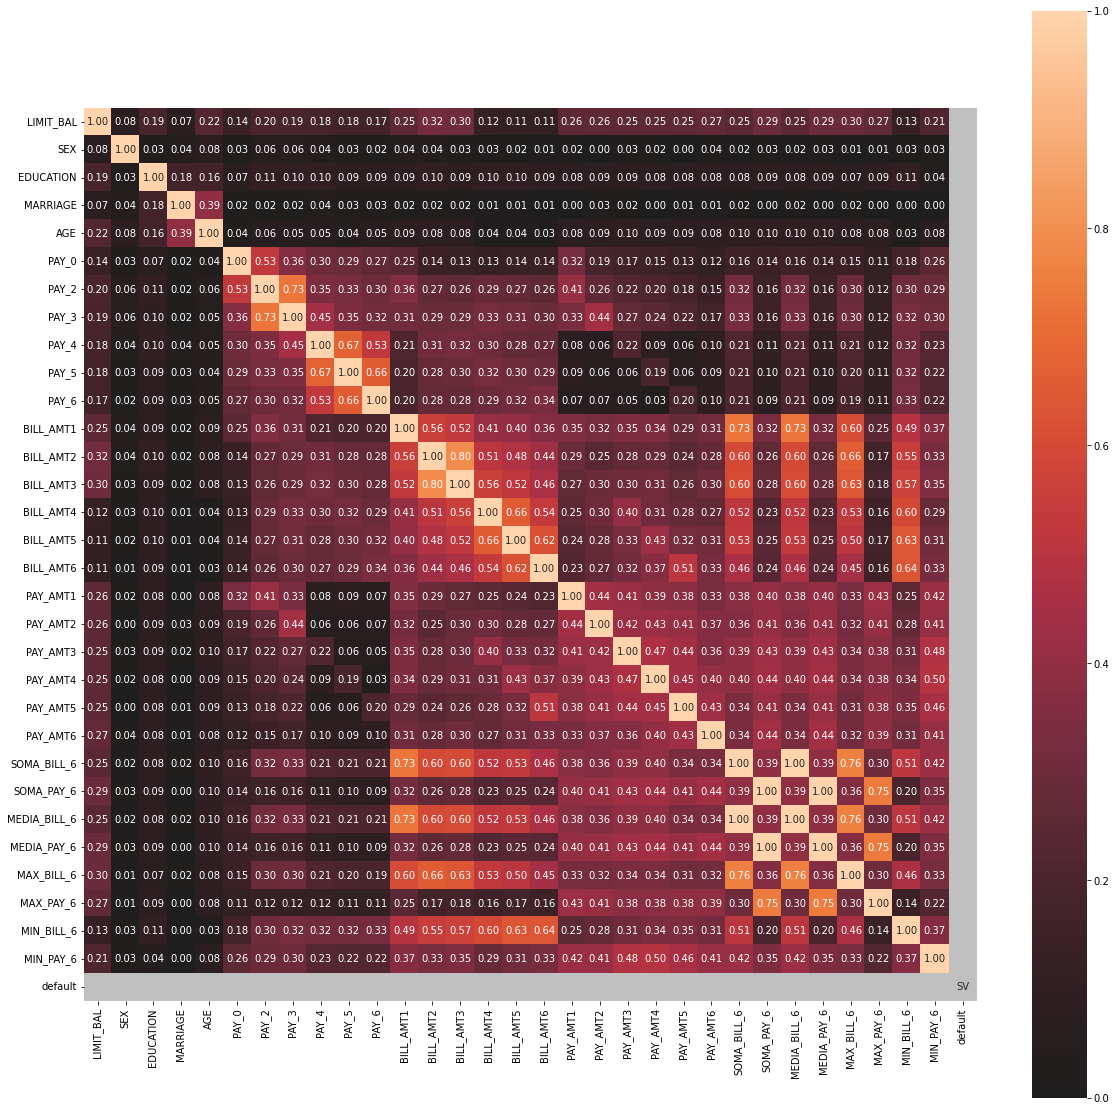

In [ ]:
# Plotando a matrix de associacao de CrammerV
complete_correlation= associations(X_train_CAT, filename= 'complete_correlation.png', figsize=(20,20))


### 08.2. Filtros

Visando um modelo de behaviour score, podemos descartar variáveis cadastrais, variáveis com IV abaixo de 1% e com associação > 0.6

In [ ]:
# Realizando a primeira eliminação
neon_filtro = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'SOMA_BILL_6', 'SOMA_PAY_6', 'MEDIA_BILL_6', 'MEDIA_PAY_6',
       'MAX_BILL_6', 'MAX_PAY_6', 'MIN_BILL_6', 'MIN_PAY_6']

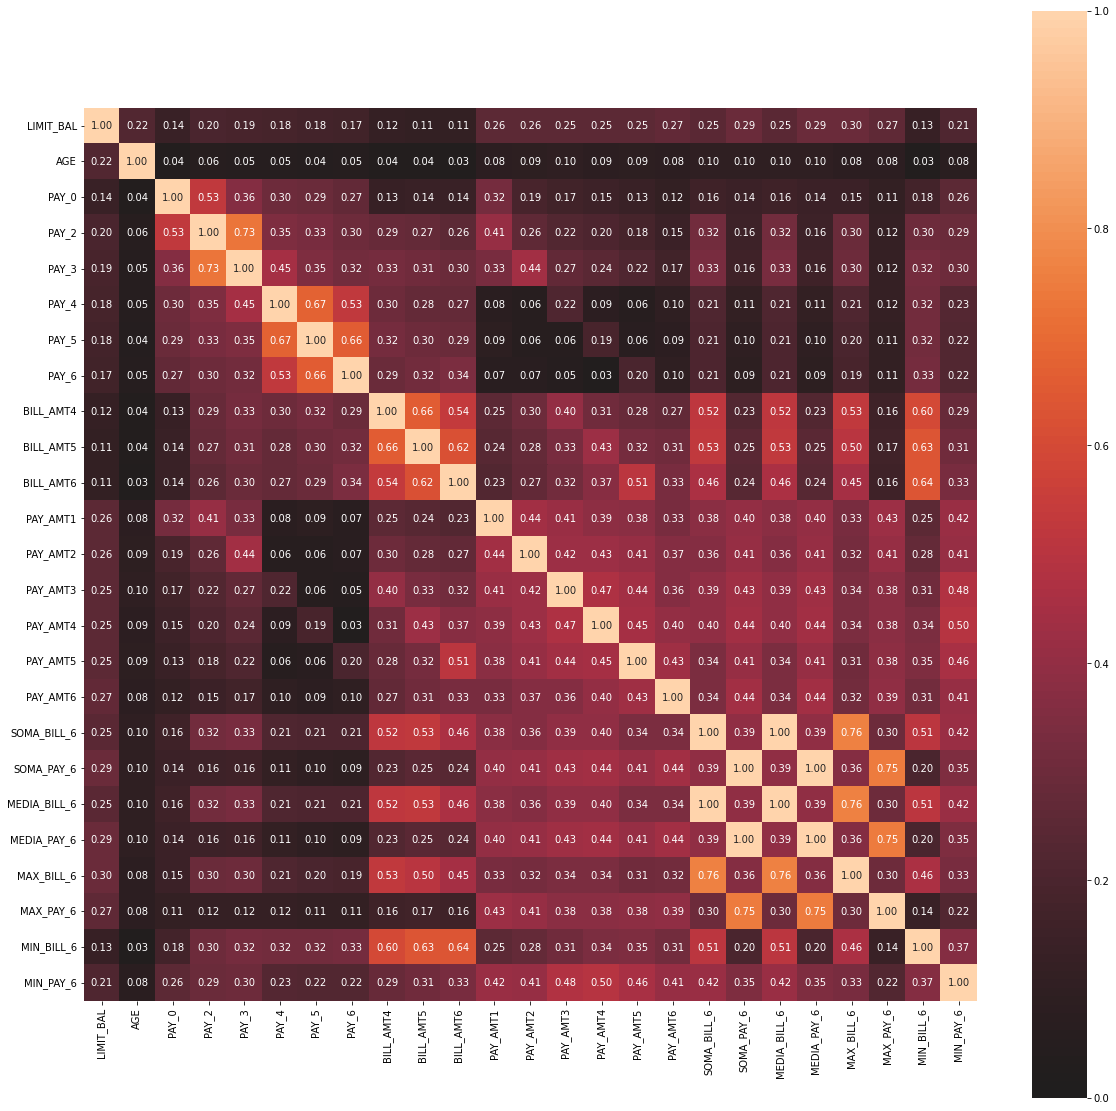

In [ ]:
#Plotando a matrix considerando o primeiro filtro
complete_correlation= associations(X_train_CAT[neon_filtro], filename= 'complete_correlation.png', figsize=(20,20))


In [ ]:
# Realizando a segundo eliminação, as vars com asso > 0.6 serão mantidas as que tiverem maior IV
# eliminando BILL_AMT5, MAX_BILL_6 e MAX_PAY_6, SOMA_BILL_6,SOMA_PAY_6
neon_filtro2 = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT4', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
         'MEDIA_BILL_6', 'MEDIA_PAY_6',
        'MIN_BILL_6', 'MIN_PAY_6']

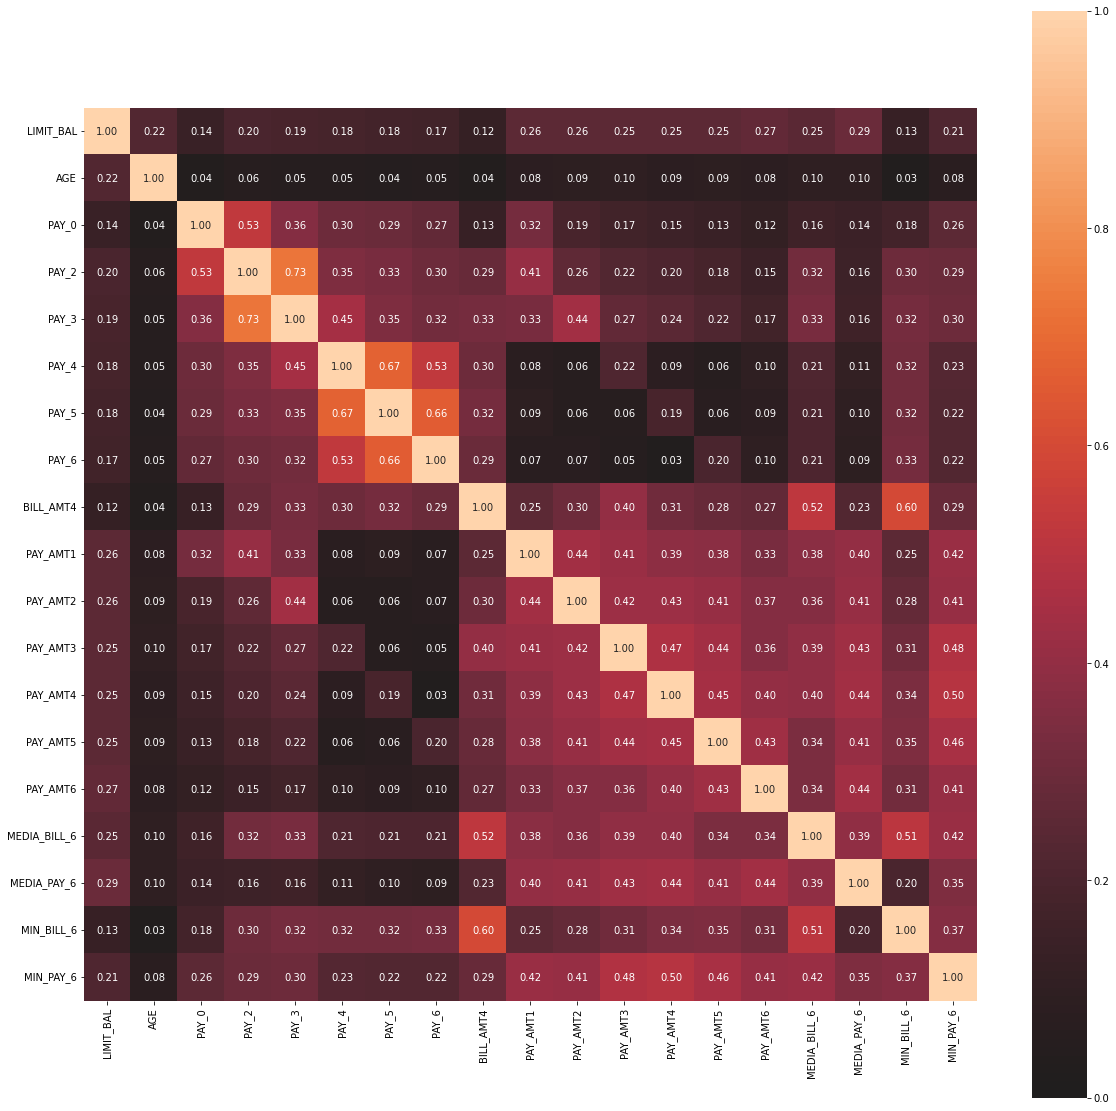

In [ ]:
# Plotando a matrix considerando o primeiro filtro
# Finalizando os filtros com todas variáveis sem associacoes altas
complete_correlation= associations(X_train_CAT[neon_filtro2], filename= 'complete_correlation.png', figsize=(20,20))


# 08. MODELAGEM

### 08.1 Passo1

In [ ]:

y = y_train.reset_index()
y.head()


,index,default
0,10910,1
1,12563,0
2,369,1
3,7702,0
4,7464,0


In [ ]:
neon_filtro2

['LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT4',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'MEDIA_BILL_6',
 'MEDIA_PAY_6',
 'MIN_BILL_6',
 'MIN_PAY_6']

In [ ]:
import statsmodels.formula.api as smf
log_reg = smf.logit(formula = " y['default'] ~ C(LIMIT_BAL, Treatment(reference=0)) + \
                                         C(AGE, Treatment(reference=0)) + \
                                          C(PAY_0, Treatment(reference=0)) + \
                                          C(PAY_3, Treatment(reference=0)) + \
                                          C(PAY_4, Treatment(reference=0)) + \
                                          C(PAY_5, Treatment(reference=0)) + \
                                          C(PAY_6, Treatment(reference=0)) + \
                                          C(BILL_AMT4, Treatment(reference=0)) + \
                                          C(PAY_AMT1, Treatment(reference=0)) + \
                                          C(PAY_AMT2, Treatment(reference=0)) + \
                                          C(PAY_AMT3, Treatment(reference=0)) + \
                                          C(PAY_AMT4, Treatment(reference=0)) + \
                                          C(PAY_AMT5, Treatment(reference=0)) + \
                                          C(PAY_AMT6, Treatment(reference=0)) + \
                                          C(MEDIA_BILL_6, Treatment(reference=0)) + \
                                          C(MEDIA_PAY_6, Treatment(reference=0)) + \
                                          C(MIN_BILL_6, Treatment(reference=0)) + \
                                          C(MIN_PAY_6, Treatment(reference=0)) \
                                     ", data=X_train_CAT ).fit()

Optimization terminated successfully.
         Current function value: 0.444325
         Iterations 6


In [ ]:
print(log_reg.summary2())

                                                Results: Logit
Model:                             Logit                           Pseudo R-squared:                0.176     
Dependent Variable:                y['default']                    AIC:                             13137.1588
Date:                              2022-05-25 23:43                BIC:                             13418.1961
No. Observations:                  14700                           Log-Likelihood:                  -6531.6   
Df Model:                          36                              LL-Null:                         -7923.7   
Df Residuals:                      14663                           LLR p-value:                     0.0000    
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    6.0000                                                                     
-------------------------------------------------

### 08.2 Passo2

In [ ]:
log_reg = smf.logit(formula = " y['default'] ~ C(LIMIT_BAL, Treatment(reference=0)) + \
                                          C(PAY_0, Treatment(reference=0)) + \
                                          C(PAY_3, Treatment(reference=0)) + \
                                          C(PAY_5, Treatment(reference=0)) + \
                                          C(BILL_AMT4, Treatment(reference=0)) + \
                                          C(PAY_AMT1, Treatment(reference=0)) + \
                                          C(PAY_AMT2, Treatment(reference=0)) + \
                                          C(PAY_AMT3, Treatment(reference=0)) + \
                                          C(PAY_AMT4, Treatment(reference=0)) + \
                                          C(PAY_AMT5, Treatment(reference=0)) + \
                                          C(PAY_AMT6, Treatment(reference=0)) + \
                                          C(MEDIA_BILL_6, Treatment(reference=0)) + \
                                          C(MEDIA_PAY_6, Treatment(reference=0)) + \
                                          C(MIN_BILL_6, Treatment(reference=0)) + \
                                          C(MIN_PAY_6, Treatment(reference=0)) \
                                     ", data=X_train_CAT ).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.444856
         Iterations 6
                                                Results: Logit
Model:                             Logit                           Pseudo R-squared:                0.175     
Dependent Variable:                y['default']                    AIC:                             13140.7550
Date:                              2022-05-26 00:10                BIC:                             13376.2186
No. Observations:                  14700                           Log-Likelihood:                  -6539.4   
Df Model:                          30                              LL-Null:                         -7923.7   
Df Residuals:                      14669                           LLR p-value:                     0.0000    
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    6.0000                 

In [ ]:
log_reg = smf.logit(formula = " y['default'] ~ C(LIMIT_BAL, Treatment(reference=0)) + \
                                          C(PAY_0, Treatment(reference=0)) + \
                                          C(PAY_3, Treatment(reference=0)) + \
                                          C(PAY_5, Treatment(reference=0)) + \
                                          C(PAY_AMT1, Treatment(reference=0)) + \
                                          C(PAY_AMT2, Treatment(reference=0)) + \
                                          C(PAY_AMT6, Treatment(reference=0)) + \
                                          C(MEDIA_BILL_6, Treatment(reference=0)) + \
                                          C(MEDIA_PAY_6, Treatment(reference=0)) + \
                                          C(MIN_BILL_6, Treatment(reference=0)) + \
                                          C(MIN_PAY_6, Treatment(reference=0)) \
                                     ", data=X_train_CAT ).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.445298
         Iterations 6
                                                Results: Logit
Model:                             Logit                           Pseudo R-squared:                0.174     
Dependent Variable:                y['default']                    AIC:                             13137.7745
Date:                              2022-05-26 00:13                BIC:                             13312.4733
No. Observations:                  14700                           Log-Likelihood:                  -6545.9   
Df Model:                          22                              LL-Null:                         -7923.7   
Df Residuals:                      14677                           LLR p-value:                     0.0000    
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    6.0000                 

### 08.3 Passo3 (Seleção final)

In [ ]:
log_reg = smf.logit(formula = " y['default'] ~ C(LIMIT_BAL, Treatment(reference=0)) + \
                                          C(PAY_0, Treatment(reference=0)) + \
                                          C(PAY_3, Treatment(reference=0)) + \
                                          C(PAY_AMT1, Treatment(reference=0)) + \
                                          C(MEDIA_PAY_6, Treatment(reference=0)) + \
                                          C(MIN_PAY_6, Treatment(reference=0)) \
                                     ", data=X_train_CAT ).fit()
print(log_reg.summary2())


# O selação final resulta na entrada de 6 variávais.

Optimization terminated successfully.
         Current function value: 0.448068
         Iterations 6
                                                Results: Logit
Model:                             Logit                           Pseudo R-squared:                0.169     
Dependent Variable:                y['default']                    AIC:                             13199.1964
Date:                              2022-05-26 00:15                BIC:                             13297.9393
No. Observations:                  14700                           Log-Likelihood:                  -6586.6   
Df Model:                          12                              LL-Null:                         -7923.7   
Df Residuals:                      14687                           LLR p-value:                     0.0000    
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    6.0000                 

### 08.4 Ajustando as bases para score (TREINO)

In [ ]:
lista_final=['LIMIT_BAL','PAY_0','PAY_3','PAY_AMT1','MEDIA_PAY_6','MIN_PAY_6']
neon_final_treino=X_train[lista_final]
neon_final_teste=X_test[lista_final]
neon_final_oot=OOT[lista_final]


In [ ]:
# Intercept
neon_final_treino['Intercept'] = -0.9976

In [ ]:
# LIMIT_BAL
neon_final_treino.loc[neon_final_treino['LIMIT_BAL'] < 45000.00 , 'LIMIT_BAL_trat'] = 0
neon_final_treino.loc[(neon_final_treino['LIMIT_BAL'] >= 45000.00) & (neon_final_treino['LIMIT_BAL'] < 125000.00), 'LIMIT_BAL_trat'] = -0.1514
neon_final_treino.loc[neon_final_treino['LIMIT_BAL'] >= 125000.00, 'LIMIT_BAL_trat'] = -0.2361

In [ ]:
# PAY_0
neon_final_treino.loc[neon_final_treino['PAY_0'] < 1 , 'PAY_0_trat'] = 0
neon_final_treino.loc[neon_final_treino['PAY_0'] == 1, 'PAY_0_trat'] = 0.6434
neon_final_treino.loc[neon_final_treino['PAY_0'] > 1, 'PAY_0_trat'] = 2.1111

In [ ]:
# PAY_3
neon_final_treino.loc[neon_final_treino['PAY_3'] == 0 , 'PAY_3_trat'] = 0
neon_final_treino.loc[neon_final_treino['PAY_3'] == -1 , 'PAY_3_trat'] = 0
neon_final_treino.loc[neon_final_treino['PAY_3'] == 1, 'PAY_3_trat'] = -0.2036
neon_final_treino.loc[neon_final_treino['PAY_3'] == -2, 'PAY_3_trat'] = -0.2036
neon_final_treino.loc[neon_final_treino['PAY_3'] > 1, 'PAY_3_trat'] = 0.5485


In [ ]:
# PAY_AMT1
neon_final_treino.loc[neon_final_treino['PAY_AMT1'] < 21.50 , 'PAY_AMT1_trat'] = 0
neon_final_treino.loc[(neon_final_treino['PAY_AMT1'] >= 21.50) & (neon_final_treino['PAY_AMT1'] < 4902.50), 'PAY_AMT1_trat'] = -0.2882
neon_final_treino.loc[neon_final_treino['PAY_AMT1'] > 4902.50, 'PAY_AMT1_trat'] = -0.4867

In [ ]:
# MEDIA_PAY_6
neon_final_treino.loc[neon_final_treino['MEDIA_PAY_6'] < 2217.08 , 'MEDIA_PAY_6_trat'] = 0
neon_final_treino.loc[(neon_final_treino['MEDIA_PAY_6'] >= 2217.08) & (neon_final_treino['MEDIA_PAY_6'] < 10116.92), 'MEDIA_PAY_6_trat'] = -0.2411
neon_final_treino.loc[neon_final_treino['MEDIA_PAY_6'] > 10116.92, 'MEDIA_PAY_6_trat'] = -0.6016

In [ ]:
# MIN_PAY_6
neon_final_treino.loc[neon_final_treino['MIN_PAY_6'] < 7.50 , 'MIN_PAY_6_trat'] = 0
neon_final_treino.loc[(neon_final_treino['MIN_PAY_6'] >= 7.50) & (neon_final_treino['MIN_PAY_6'] < 1601.50), 'MIN_PAY_6_trat'] = -0.2682
neon_final_treino.loc[neon_final_treino['MIN_PAY_6'] > 10116.92, 'MIN_PAY_6_trat'] = -0.3705                           

### 08.5 Ajustando as bases para score (VALIDACAO)

In [ ]:
# Intercept
neon_final_teste['Intercept'] = -0.9976

In [ ]:
# LIMIT_BAL
neon_final_teste.loc[neon_final_teste['LIMIT_BAL'] < 45000.00 , 'LIMIT_BAL_trat'] = 0
neon_final_teste.loc[(neon_final_teste['LIMIT_BAL'] >= 45000.00) & (neon_final_teste['LIMIT_BAL'] < 125000.00), 'LIMIT_BAL_trat'] = -0.1514
neon_final_teste.loc[neon_final_teste['LIMIT_BAL'] >= 125000.00, 'LIMIT_BAL_trat'] = -0.2361

In [ ]:
# PAY_0
neon_final_teste.loc[neon_final_teste['PAY_0'] < 1 , 'PAY_0_trat'] = 0
neon_final_teste.loc[neon_final_teste['PAY_0'] == 1, 'PAY_0_trat'] = 0.6434
neon_final_teste.loc[neon_final_teste['PAY_0'] > 1, 'PAY_0_trat'] = 2.1111

In [ ]:
# PAY_3
neon_final_teste.loc[neon_final_teste['PAY_3'] == 0 , 'PAY_3_trat'] = 0
neon_final_teste.loc[neon_final_teste['PAY_3'] == -1 , 'PAY_3_trat'] = 0
neon_final_teste.loc[neon_final_teste['PAY_3'] == 1, 'PAY_3_trat'] = -0.2036
neon_final_teste.loc[neon_final_teste['PAY_3'] == -2, 'PAY_3_trat'] = -0.2036
neon_final_teste.loc[neon_final_teste['PAY_3'] > 1, 'PAY_3_trat'] = 0.5485


In [ ]:
# PAY_AMT1
neon_final_teste.loc[neon_final_teste['PAY_AMT1'] < 21.50 , 'PAY_AMT1_trat'] = 0
neon_final_teste.loc[(neon_final_teste['PAY_AMT1'] >= 21.50) & (neon_final_teste['PAY_AMT1'] < 4902.50), 'PAY_AMT1_trat'] = -0.2882
neon_final_teste.loc[neon_final_teste['PAY_AMT1'] > 4902.50, 'PAY_AMT1_trat'] = -0.4867

In [ ]:
# MEDIA_PAY_6
neon_final_teste.loc[neon_final_teste['MEDIA_PAY_6'] < 2217.08 , 'MEDIA_PAY_6_trat'] = 0
neon_final_teste.loc[(neon_final_teste['MEDIA_PAY_6'] >= 2217.08) & (neon_final_teste['MEDIA_PAY_6'] < 10116.92), 'MEDIA_PAY_6_trat'] = -0.2411
neon_final_teste.loc[neon_final_teste['MEDIA_PAY_6'] > 10116.92, 'MEDIA_PAY_6_trat'] = -0.6016

In [ ]:
# MIN_PAY_6
neon_final_teste.loc[neon_final_teste['MIN_PAY_6'] < 7.50 , 'MIN_PAY_6_trat'] = 0
neon_final_teste.loc[(neon_final_teste['MIN_PAY_6'] >= 7.50) & (neon_final_teste['MIN_PAY_6'] < 1601.50), 'MIN_PAY_6_trat'] = -0.2682
neon_final_teste.loc[neon_final_teste['MIN_PAY_6'] > 10116.92, 'MIN_PAY_6_trat'] = -0.3705

### 08.6 Ajustando as bases para score (OOT)

In [ ]:
# Intercept
neon_final_oot['Intercept'] = -0.9976

In [ ]:
# LIMIT_BAL
neon_final_oot.loc[neon_final_oot['LIMIT_BAL'] < 45000.00 , 'LIMIT_BAL_trat'] = 0
neon_final_oot.loc[(neon_final_oot['LIMIT_BAL'] >= 45000.00) & (neon_final_oot['LIMIT_BAL'] < 125000.00), 'LIMIT_BAL_trat'] = -0.1514
neon_final_oot.loc[neon_final_oot['LIMIT_BAL'] >= 125000.00, 'LIMIT_BAL_trat'] = -0.2361

In [ ]:
# PAY_0
neon_final_oot.loc[neon_final_oot['PAY_0'] < 1 , 'PAY_0_trat'] = 0
neon_final_oot.loc[neon_final_oot['PAY_0'] == 1, 'PAY_0_trat'] = 0.6434
neon_final_oot.loc[neon_final_oot['PAY_0'] > 1, 'PAY_0_trat'] = 2.1111

In [ ]:
# PAY_3
neon_final_oot.loc[neon_final_oot['PAY_3'] == 0 , 'PAY_3_trat'] = 0
neon_final_oot.loc[neon_final_oot['PAY_3'] == -1 , 'PAY_3_trat'] = 0
neon_final_oot.loc[neon_final_oot['PAY_3'] == 1, 'PAY_3_trat'] = -0.2036
neon_final_oot.loc[neon_final_oot['PAY_3'] == -2, 'PAY_3_trat'] = -0.2036
neon_final_oot.loc[neon_final_oot['PAY_3'] > 1, 'PAY_3_trat'] = 0.5485


In [ ]:
# PAY_AMT1
neon_final_oot.loc[neon_final_oot['PAY_AMT1'] < 21.50 , 'PAY_AMT1_trat'] = 0
neon_final_oot.loc[(neon_final_oot['PAY_AMT1'] >= 21.50) & (neon_final_oot['PAY_AMT1'] < 4902.50), 'PAY_AMT1_trat'] = -0.2882
neon_final_oot.loc[neon_final_oot['PAY_AMT1'] > 4902.50, 'PAY_AMT1_trat'] = -0.4867

In [ ]:
# MEDIA_PAY_6
neon_final_oot.loc[neon_final_oot['MEDIA_PAY_6'] < 2217.08 , 'MEDIA_PAY_6_trat'] = 0
neon_final_oot.loc[(neon_final_oot['MEDIA_PAY_6'] >= 2217.08) & (neon_final_oot['MEDIA_PAY_6'] < 10116.92), 'MEDIA_PAY_6_trat'] = -0.2411
neon_final_oot.loc[neon_final_oot['MEDIA_PAY_6'] > 10116.92, 'MEDIA_PAY_6_trat'] = -0.6016

In [ ]:
# MIN_PAY_6
neon_final_oot.loc[neon_final_oot['MIN_PAY_6'] < 7.50 , 'MIN_PAY_6_trat'] = 0
neon_final_oot.loc[(neon_final_oot['MIN_PAY_6'] >= 7.50) & (neon_final_oot['MIN_PAY_6'] < 1601.50), 'MIN_PAY_6_trat'] = -0.2682
neon_final_oot.loc[neon_final_oot['MIN_PAY_6'] > 10116.92, 'MIN_PAY_6_trat'] = -0.3705

### 08.7 Predição

In [ ]:
lista_score=['Intercept','LIMIT_BAL_trat','PAY_0_trat','PAY_3_trat','PAY_AMT1_trat','MEDIA_PAY_6_trat','MIN_PAY_6_trat']

In [ ]:
# função de ligação G(x)

# Treino
neon_final_treino['G'] = neon_final_treino[lista_score].sum(axis=1)

# Validação
neon_final_teste['G'] = neon_final_teste[lista_score].sum(axis=1)

# OOT
neon_final_oot['G'] = neon_final_oot[lista_score].sum(axis=1)


In [ ]:
# Probabilidades/Scores
neon_final_treino['score'] = round((1 / (1 + np.exp(-neon_final_treino['G'])))*1000)

neon_final_teste['score'] = round((1 / (1 + np.exp(-neon_final_teste['G'])))*1000)

neon_final_oot['score'] = round((1 / (1 + np.exp(-neon_final_oot['G'])))*1000)


# 09. AVALIAÇÃO DO MODELO

### 9.01 Faixas de Score DEV

In [ ]:
# Testando a divisão de faixas, com 8 é melhor que adere, apesar de não termos o mesmo volume em todas com outras divisoes.
neon_final_treino['faixas']  = pd.qcut(neon_final_treino['score'], 8, labels = False)
intervalos = list(neon_final_treino.groupby(['faixas']).agg({'score': [np.max]})['score']['amax'])
intervalos

In [ ]:
neon_final_treino['safra']= X_train['Safra']
neon_final_treino['target']= y_train

In [ ]:
#KS
stats.ks_2samp(neon_final_treino['score'].loc[neon_final_treino['target'] == 1], neon_final_treino['score'].loc[neon_final_treino['target'] == 0])


### 9.02 Faixas de Score VALIDACAO

In [ ]:
neon_final_teste['safra']= X_test['Safra']
neon_final_teste['target']= y_test

In [ ]:
# Aplicando a regra de quebra de faixa do DEV na VAL
def fx_score(score):
    if score <= intervalos[0]:
        return 0
    elif score <= intervalos[1]:
        return 1
    elif score <= intervalos[2]:
        return 2
    elif score <= intervalos[3]:
        return 3
    elif score <= intervalos[4]:
        return 4
    elif score <= intervalos[5]:
        return 5
    elif score <= intervalos[6]:
        return 6
    elif score <= intervalos[7]:
        return 7
    elif score <= intervalos[8]:
        return 8
    return -1

neon_final_teste['fx_score_VAL'] = neon_final_teste['score'].map(fx_score)

In [ ]:
#KS 40%
stats.ks_2samp(neon_final_teste['score'].loc[neon_final_teste['target'] == 1], neon_final_teste['score'].loc[neon_final_teste['target'] == 0])


KstestResult(statistic=0.40189400746185433, pvalue=3.3306690738754696e-16)

### 9.03 Faixas de Score VALIDACAO

In [ ]:
neon_final_oot['safra']= OOT['Safra']
neon_final_oot['target']=OOT['default.payment.next.month']

In [ ]:
# Aplicando a regra de quebra de faixa do DEV na VAL
def fx_score(score):
    if score <= intervalos[0]:
        return 0
    elif score <= intervalos[1]:
        return 1
    elif score <= intervalos[2]:
        return 2
    elif score <= intervalos[3]:
        return 3
    elif score <= intervalos[4]:
        return 4
    elif score <= intervalos[5]:
        return 5
    elif score <= intervalos[6]:
        return 6
    elif score <= intervalos[7]:
        return 7
    elif score <= intervalos[8]:
        return 8
    return -1

neon_final_oot['fx_score_OOT'] = neon_final_oot['score'].map(fx_score)

In [ ]:
#KS 41 %
stats.ks_2samp(neon_final_oot['score'].loc[neon_final_oot['target'] == 1], neon_final_oot['score'].loc[neon_final_oot['target'] == 0])


KstestResult(statistic=0.4159734029633228, pvalue=4.471545356210527e-11)

In [ ]:
neon_final_treino.to_csv('/content/drive/MyDriveDEV/neon_final_treino.csv',index=None)
#neon_final_teste.to_csv('/content/drive/MyDrive/VAL.csv',index=None)
#neon_final_oot.to_csv('/content/drive/MyDrive/OOT.csv',index=None)

# 10 CONSIDERAÇÕES FINAIS

Essa é uma versão bem simplificada de todo o processo, não foi levando em conta:

- Correlação de pearson com os dados contínuos
- Categorização com árvore
- Avaliação das categorias ao logo do tempo pelo WoE
- Criação de dummy
- Avaliação mensal do KS e KS1 ao mês dentro do OOT
- Avaliacão da estabilidade das variáveis no DEV e no OOT.
- Os códigos não são otimizados por não a minha linguagem "nativa" na programação.
